In [40]:
import numba, numpy, pandas
from lmfit.models import GaussianModel
import matplotlib.pyplot as plt

# Funtion definitions

In [41]:
@numba.njit
def fir(ntaps , tf, tft, tr):
	c = numpy.zeros(ntaps)
	for j in range(ntaps):
		i = j + 1
		if 1 <= i <= tf:
			c[j] = (-1/tf) + 6 * ((1 + tf - 2 * (i))/(tf**3 - tf)) * (0.5 * tf + tft + 0.5 * tr)
		elif tf <= i and i <= tf + tft:
			c[j] = 0
		elif tf + tft < i and i <= tf + tft +tr:
			c[j] = 1/tr
	return c

def get_pulses(column):
	pulses = numpy.zeros((column.shape[0]//512, 512))
	for i in range(0, column.shape[0] // 512):
		pulses[i] = column.loc[i * 512 : 511 + i *512]
	return pandas.DataFrame(data = pulses)#, index = range(column.shape[0] // 512))

def apply_filter (signal, fir, fix_point):
	lcorr = numpy.correlate(signal.ravel(), fir, 'valid')
	return max(lcorr), lcorr[fix_point]

# 160 mid of flattop 195 (arrival time) - 80 (nr coef) + 35 + (tft/2)

def arb2eV(axis, x0, y0):
	p = (y0) / (x0)
	if isinstance(axis, list):
		return [i*p for i in axis]
	else:
		return axis*p

def draw_hist(data, bin_size):
	return plt.hist( data, bins = numpy.arange(min(data), max(data) + bin_size, bin_size))
	

# Constants

In [42]:
############################################################################
## data analysis 
nch = 8             # number of channels in the input file
sph = 512           # number of samples per photon
nph = 17513           # number of photon segments per channel
chn = 1             # selected channel from [0-7]
#npht =             # total number of photons
    
############################################################################
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Main Script

- Load photons data
  - Plot data
- Load filters coefficients
  - Plot filters
- Apply filters to data
  - Generate histogram of amplitudes
- Fit histogram with Guassian
  - Plot histogram + fit 
  - Caluclate FWHM

## Load Data

In [43]:
data = pandas.read_csv("001_Mn_1x1mm_fastspectrum_2015-09-17_15-47-raw.csv", delimiter='\t', engine='python', dtype='int', skip_blank_lines=True, usecols= ['CH4'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499648 entries, 0 to 1499647
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   CH4     1499648 non-null  int32
dtypes: int32(1)
memory usage: 5.7 MB


In [44]:
pulses = numpy.zeros((data.shape[0]//512, 512))
pulses = get_pulses(data.iloc[:,0]).to_numpy()
for i in range(1, data.shape[1]):
	pulses = numpy.append(pulses, get_pulses(data.iloc[:,i]), axis =0)
pulses.shape

(2929, 512)

## Load Filters' Coefficients

In [45]:
#long_fir_opt = pandas.read_csv("long_fir_opt.csv", delimiter=',', header=None, usecols=[1]).transpose()
#long_fir_opt.info()
#long_fir_opt = long_fir_opt.to_numpy()[0]
#long_fir_opt = [0.138632, 0.121977, 0.107061, 0.09367, 0.0816141, 0.0707213, 0.0608364, 0.0518185, 0.0435392, 0.0358804, 0.0287331, 0.0219954, 0.0155713, 0.00936939, 0.00330117, -0.00271976, -0.00877917, -0.0149634, -0.0213605, -0.0280617, -0.0351625, -0.0427639, -0.0509744, -0.0599108, -0.0697005, -0.0804831, -0.0924122, -0.105658, -0.120408, -0.136874, -0.155291, -0.175919, -0.199054, -0.225026, -0.254203, -0.00856725, 0.00492805, -0.000391479, -0.00439062, 0.00980198, -0.0166084, 0.0257754, -0.0384315, 0.0552759, 0.0762594, -0.0887168, -0.124073, -0.0991312, -0.0514442, -0.000342207, 0.0450901, 0.0813579, 0.107875, 0.125448, 0.135441, 0.13934, 0.138531, 0.134215, 0.12738, 0.118809, 0.109108, 0.098724, 0.0879836, 0.0771098, 0.0662466, 0.0554747, 0.0448264, 0.0342956, 0.0238463, 0.0134192, 0.00293539, -0.00769989, -0.0185956, -0.0298738, -0.0416693, -0.0541299, -0.0674175, -0.0817091, -0.0971989, -0.1141]
#[0.135881, 0.119571, 0.104964, 0.0918536, 0.080052, 0.0693912, 0.0597194, 0.0508987, 0.0428034, 0.0353182, 0.0283365, 0.0217587, 0.0154911, 0.00944455, 0.00353277, -0.00232843, -0.00822252, -0.0142335, -0.020447, -0.0269516, -0.0338399, -0.04121, -0.049167, -0.0578243, -0.0673051, -0.0777446, -0.0892916, -0.102111, -0.116384, -0.132316, -0.150133, -0.170088, -0.192468, -0.217589, -0.245811, -0.0795875, 0.0299723, -0.00192723, -0.00301668, 0.000524161, 0.00272766, -0.00270093, -0.0174668, 0.0791217, 0.0341126, -0.099639, -0.120426, -0.08992, -0.0412936, 0.00858373, 0.0519664, 0.086054, 0.110591, 0.126515, 0.135217, 0.138157, 0.136676, 0.131925, 0.124841, 0.116166, 0.106468, 0.0961683, 0.0855687, 0.0748754, 0.0642192, 0.0536716, 0.0432579, 0.0329676, 0.0227622, 0.0125807, 0.00234413, -0.00804186, -0.018685, -0.0297052, -0.0412355, -0.0534208, -0.0664199, -0.0804064, -0.0955707, -0.112122]
#long_fir_opt = [0.185915, 0.164726, 0.145761, 0.128991, 0.113953, 0.100654, 0.0887049, 0.0780204, 0.0685413, 0.0597931, 0.0522146, 0.0451995, 0.0389163, 0.0331786, 0.0278245, 0.0228691, 0.0183114, 0.0141247, 0.00987741, 0.00588261, 0.00205595, -0.00189917, -0.00575574, -0.00960218, -0.0138645, -0.0179541, -0.0225647, -0.0277789, -0.0327033, -0.0385711, -0.0446397, -0.0518263, -0.0593154, -0.0679029, -0.0773032, -0.0879404, -0.0997707, -0.113038, -0.127953, -0.144598, -0.16304, -0.184498, -0.208002, -0.234664, -0.264731, -0.224238, -0.107546, -0.0131769, 0.022357, 0.0191647, 0.00763138, 0.00103739, -0.00331648, -0.0129828, -0.0237987, -0.0144137, 0.0446263, 0.149734, 0.217329, 0.124338, -0.0381243, -0.143411,-0.204463, -0.231736, -0.233914, -0.218057, -0.189387, -0.151747, -0.108042, -0.061008, -0.012053, 0.0377043, 0.0876871, 0.137256, 0.18557, 0.233983, 0.281615, 0.329942, 0.378142, 0.427698]
#long_fir_opt =[0.26392,0.232831,0.20506,0.180211,0.157931,0.137901,0.119836,0.103479,0.088597,0.0749778,0.0624272,0.0507666,0.0398298,0.0294609,0.0195123,0.00984222,0.000312912,-0.00921137,-0.0188663,-0.0287894,-0.0391221,-0.0500115,-0.0616129,-0.0740914,-0.0876248,-0.102406,-0.118646,-0.136575,-0.15645,-0.178553,-0.203199,-0.23074,-0.261569,-0.296123,-0.334897,-0.283382,-0.13441,-0.0160917,0.0227522,0.0103435,-0.00230163,0.0209993,0.0792217,0.120284,0.0708471,-0.0184838,-0.0754403,-0.107886,-0.122092,-0.123031,-0.114619,-0.0999105,-0.0812709,-0.0605056,-0.0389735,-0.0176778,0.00265973,0.0215383,0.0386287,0.0537337,0.0667557,0.077671,0.0865094,0.0933375,0.0982459,0.101339,0.102726,0.102517,0.100816,0.0977191,0.0933089,0.0876554,0.0808127,0.0728179,0.0636902,0.0534295,0.042016,0.0294089,0.0155452,0.000338937]
#long_fir_opt = [0.555525,0.31233,0.176912,0.101271,0.0587842,0.0346867,0.0207883,0.0125467,0.00744253,0.00407853,0.00167962,-0.0001841,-0.00175113,-0.00315387,-0.00446598,-0.00572871,-0.00696565,-0.00819114,-0.00941546,-0.0106485,-0.0119031,-0.0132,-0.0145751,-0.016092,-0.0178653,-0.0201012,-0.0231712,-0.0277453,-0.0350312,-0.0472064,-0.0681972,-0.105082,-0.170624,-0.287833,-0.498198,-0.548968,-0.32855,-0.0957104,0.0142798,0.0259955,0.0278328,0.0861946,0.187756,0.215051,0.0314932,-0.177267,-0.242858,-0.238177,-0.202149,-0.155097,-0.107226,-0.0633007,-0.0252122,0.00662084,0.0324945,0.0530153,0.068889,0.0808158,0.0894414,0.0953377,0.0989999,0.10085,0.101243,0.100477,0.0987977,0.0964075,0.0934705,0.0901162,0.0864408,0.0825063,0.0783327,0.0738823,0.0690271,0.0634887,0.0567278,0.0477421,0.0347017,0.0142902,-0.0194842,-0.0774343]
#long_fir_opt = [0.493814,0.277713,0.157384,0.0901746,0.0524264,0.0310188,0.0186744,0.0113566,0.00682684,0.00384341,0.0017176,0.0000674169,-0.00131903,-0.00255933,-0.00371881,-0.00483387,-0.00592506,-0.00700437,-0.00807955,-0.00915687,-0.0102434,-0.0113494,-0.0124921,-0.0137021,-0.0150338,-0.0165852,-0.0185329,-0.0211952,-0.025146,-0.0314198,-0.041882,-0.0598959,-0.0915254,-0.147703,-0.248142,-0.336974,-0.34447,-0.279352,-0.175411,-0.0673425,0.0172348,0.0585756,0.0447909,-0.0242064,-0.124929,-0.186898,-0.1861,-0.15709,-0.117932,-0.0777196,-0.0407202,-0.00864789,0.0180933,0.0397372,0.0567964,0.0698753,0.0795761,0.0864552,0.0910061,0.093656,0.0947687,0.0946509,0.0935588,0.0917046,0.0892633,0.086377,0.0831596,0.0796988,0.0760571,0.0722689,0.0683333,0.0641983,0.0597295,0.054653,0.0484505,0.0401683,0.0280729,0.00902901,-0.0226239,-0.0770958]
#long_fir_opt = [0.487973,0.274435,0.155534,0.0891214,0.0518214,0.0306681,0.0184705,0.0112401,0.00676453,0.00381698,0.00171689,0.0000867982,-0.00128269,-0.00250775,-0.00365292,-0.00475418,-0.00583179,-0.00689755,-0.00795903,-0.00902228,-0.010094,-0.0111838,-0.0123079,-0.0134947,-0.0147951,-0.0163006,-0.0181759,-0.0207183,-0.0244633,-0.0303765,-0.0401992,-0.0570705,-0.0866503,-0.139143,-0.232948,-0.317861,-0.329534,-0.273819,-0.180438,-0.0814021,-0.00310084,0.035375,0.0229801,-0.0395228,-0.129514,-0.182832,-0.178545,-0.148687,-0.10996,-0.0707312,-0.0348909,-0.00396514,0.0217282,0.0424554,0.0587348,0.0711629,0.0803287,0.0867737,0.0909767,0.0933516,0.0942502,0.093969,0.0927553,0.0908141,0.0883137,0.0853913,0.0821562,0.0786926,0.0750599,0.0712902,0.0673809,0.0632787,0.0588487,0.0538175,0.0476688,0.0394534,0.027447,0.00853063,-0.0229254,-0.0770756]
long_fir_opt = [0.269145,0.151438,0.085899,0.0492945,0.0287382,0.0170828,0.0103641,0.00638362,0.00392177,0.00230222,0.00114985,0.000256578,-0.000492997,-0.00116289,-0.00178864,-0.00238997,-0.00297788,-0.00355858,-0.0041357,-0.00471158,-0.00528813,-0.00586749,-0.00645281,-0.00704937,-0.00766646,-0.00832072,-0.00904209,-0.0098845,-0.0109452,-0.0123994,-0.0145631,-0.0180061,-0.0237556,-0.0336636,-0.0510695,-0.0732515,-0.0938098,-0.110266,-0.122109,-0.129719,-0.133758,-0.134805,-0.133077,-0.128126,-0.118397,-0.100476,-0.0762116,-0.0512577,-0.0282691,-0.00831562,0.00834729,0.0218609,0.0325402,0.0407579,0.0468855,0.0512667,0.0542064,0.0559687,0.0567786,0.0568256,0.0562686,0.0552392,0.0538462,0.0521789,0.0503099,0.0482974,0.0461872,0.0440135,0.0417988,0.0395522,0.0372655,0.0349039,0.0323895,0.02957,0.0261623,0.0216491,0.0150939,0.00480471,-0.0122702,-0.0416337]

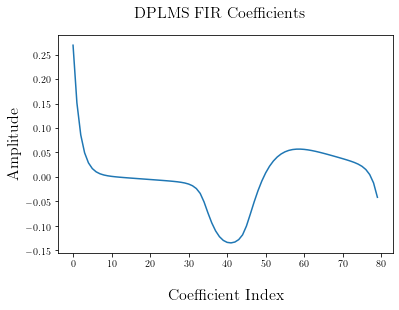

In [46]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Coefficient Index ',fontsize=16, labelpad=20)
plt.ylabel(r'Amplitude ',fontsize=16)
plt.suptitle(r'DPLMS FIR Coefficients', fontsize=16)
plt.plot(long_fir_opt)
plt.show()

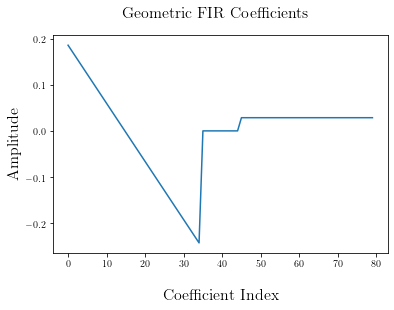

In [47]:
long_fir = fir(80, 35, 10, 35)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Coefficient Index ',fontsize=16, labelpad=20)
plt.ylabel(r'Amplitude ',fontsize=16)
plt.suptitle(r'Geometric FIR Coefficients', fontsize=16)
plt.plot(long_fir)
plt.show()

## Apply Filters to Data

155

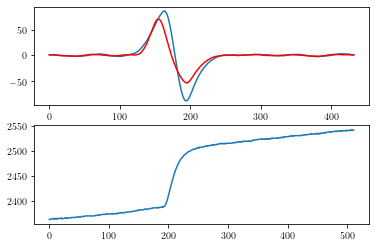

In [48]:
fig, axes = plt.subplots(2)
axes[0].plot(numpy.correlate(pulses[12], long_fir,'valid'))
axes[0].plot(numpy.correlate(pulses[12], long_fir_opt,'valid'), 'r')
axes[1].plot(pulses[15])
numpy.argmax(numpy.correlate(pulses[12], long_fir_opt,'valid'))

## Max Values Distribution Analysis

Analysis is performed channel-wise. Two methods are used to get the amplitude value, the maximum of the output and the average of the 4 samples around the maximum.

2929


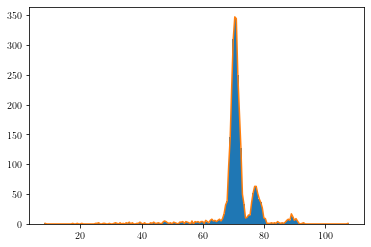

In [49]:
max_vals_opt = numpy.zeros((pulses.shape[0], 2))
max_vals_opt.shape, pulses.shape
for i, pulse in enumerate(pulses):
    max_vals_opt[i] = apply_filter(pulse, long_fir_opt, 154)
n_opt,x_opt,_ = draw_hist(max_vals_opt[:,1], 0.5)
bin_centers_opt = 0.5*(x_opt[1:] + x_opt[:-1])
plt.plot(bin_centers_opt,n_opt)
print(len(max_vals_opt))

2929


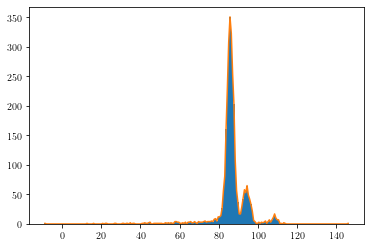

In [50]:
max_vals = numpy.zeros((pulses.shape[0], 2))
max_vals.shape, pulses.shape
for i, pulse in enumerate(pulses):
    max_vals[i] = apply_filter(pulse, long_fir, 162)
n,x,_ = draw_hist(max_vals[:,1], 0.67)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n)
print(len(max_vals))

## Histogram Fittings

### Fitting of histogram Non-Optimized Filter

-------------------------------
Parameter  	  Value 
g1_amplitude 	  1477.68436
g1_center 	    85.83041
g1_sigma 	     1.72483
g1_fwhm 	   278.72614
g1_height 	   341.77939
g2_amplitude 	   293.54168
g2_center 	    94.12507
g2_sigma 	     1.91960
g2_fwhm 	   310.20029
g2_height 	    61.00557
g3_amplitude 	    51.49076
g3_center 	   108.37938
g3_sigma 	     1.65883
g3_fwhm 	   268.06078
g3_height 	    12.38334


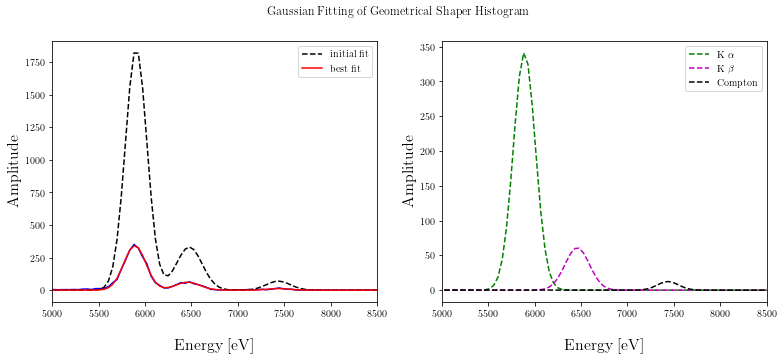

In [51]:
gauss1 = GaussianModel(prefix='g1_')
pars = gauss1.make_params()

pars.update(gauss1.make_params())

pars['g1_center'].set(value=86.03738, min=80, max=90)
pars['g1_sigma'].set(value=1.7, min=1.5)
pars['g1_amplitude'].set(value=7907.82390, min=1000)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value=94.38248, min=90, max=100)
pars['g2_sigma'].set(value=2.02785, min=1.5)
pars['g2_amplitude'].set(value=1682.05888, min=100)

gauss3 = GaussianModel(prefix='g3_')
pars.update(gauss3.make_params())

pars['g3_center'].set(value=108.37215, min=105, max=120)
pars['g3_sigma'].set(value=1.89123, min=1.5)
pars['g3_amplitude'].set(value=327.16481, min=5)

mod = gauss1 + gauss2 + gauss3

init = mod.eval(pars, x = bin_centers)
out = mod.fit(n, pars, x = bin_centers)
comps = out.eval_components(x = bin_centers)

print('-------------------------------')
print('Parameter  \t  Value ')
for name, param in out.params.items():
    if name[0] == 'g':
        if 'fwhm' in name:
            print('{:7s} \t {:11.5f}'.format(name, arb2eV( param.value, out.params['g1_center'], 5890)))
        else:
            print('{:7s} \t {:11.5f}'.format(name, param.value))
 
fig0, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))

eV0 = arb2eV(bin_centers, out.params['g1_center'], 5890) 
p = 5890 / out.params['g1_center']
axes[0].plot(eV0, n, 'b')
axes[0].plot(eV0, init, 'k--', label='initial fit')
axes[0].plot(eV0, out.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')
axes[0].set_xlim([5000, 8500])

axes[1].plot(eV0, comps['g1_'], 'g--', label='K $\\alpha$')
axes[1].plot(eV0, comps['g2_'], 'm--', label='K $\\beta$')
axes[1].plot(eV0, comps['g3_'], 'k--', label='Compton')
axes[1].legend(loc='best')
axes[1].set_xlim([5000, 8500])

axes[0].set_xlabel(r'Energy [eV]',fontsize=16, labelpad=20)
axes[0].set_ylabel(r'Amplitude ',fontsize=16)
axes[1].set_xlabel(r'Energy [eV]',fontsize=16, labelpad=20)
axes[1].set_ylabel(r'Amplitude ',fontsize=16)
fig0.suptitle(r'Gaussian Fitting of Geometrical Shaper Histogram')
plt.show()

### Fit of histogram Optimized Filter

-------------------------------
Parameter  	  Value 
g1_amplitude 	  1100.33008
g1_center 	    70.56080
g1_sigma 	     1.27178
g1_fwhm 	   249.98961
g1_height 	   345.16012
g2_amplitude 	   215.64740
g2_center 	    77.41282
g2_sigma 	     1.39783
g2_fwhm 	   274.76557
g2_height 	    61.54624
g3_amplitude 	    50.00000
g3_center 	    89.08235
g3_sigma 	     1.60985
g3_fwhm 	   316.44250
g3_height 	    12.39067


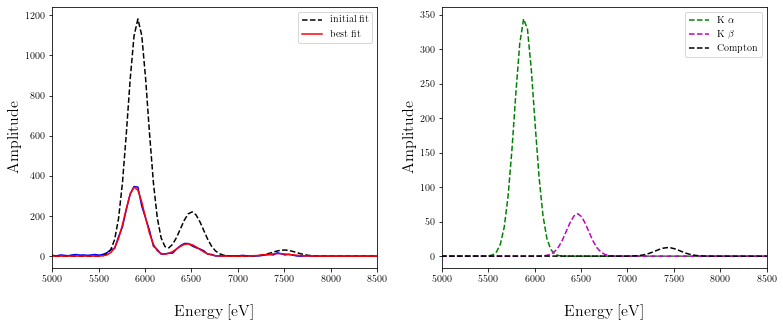

In [52]:
gauss1 = GaussianModel(prefix='g1_')
pars = gauss1.make_params()
pars.update(gauss1.make_params())

pars['g1_center'].set(value=70.95822, min=60, max=75)
pars['g1_sigma'].set(value=1.30438, min=0.3)
pars['g1_amplitude'].set(value=3864.55254, min=1000)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value=77.90659, min=70, max=80)
pars['g2_sigma'].set(value=1.48519, min=0.5)
pars['g2_amplitude'].set(value=821.38221, min=200)

gauss3 = GaussianModel(prefix='g3_')
pars.update(gauss3.make_params())

pars['g3_center'].set(value=89.84883, min=85, max=95)
pars['g3_sigma'].set(value=1.55003, min=1.3)
pars['g3_amplitude'].set(value=118.72250, min=50)

mod = gauss1 + gauss2 + gauss3

init = mod.eval(pars, x=bin_centers_opt)
out_opt = mod.fit(n_opt, pars, x=bin_centers_opt)
comps_opt = out_opt.eval_components(x=bin_centers_opt)

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))

print('-------------------------------')
print('Parameter  \t  Value ')
for name, param in out_opt.params.items():
    if name[0] == 'g':
        if 'fwhm' in name:
            print('{:7s} \t {:11.5f}'.format(name, arb2eV(param.value, out_opt.params['g1_center'], 5890)))
        else:
            print('{:7s} \t {:11.5f}'.format(name, param.value))

eV = arb2eV(bin_centers_opt, out_opt.params['g1_center'], 5890) 
p_opt = 5890 / out_opt.params['g1_center']

axes[0].plot(eV, n_opt, 'b')
axes[0].plot(eV, init, 'k--', label='initial fit')
axes[0].plot(eV, out_opt.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')
axes[0].set_xlim([5000, 8500])

axes[1].plot(eV, comps_opt['g1_'], 'g--', label='K $\\alpha$')
axes[1].plot(eV, comps_opt['g2_'], 'm--', label='K $\\beta$')
axes[1].plot(eV, comps_opt['g3_'], 'k--', label='Compton')
axes[1].legend(loc='best')
axes[1].set_xlim([5000, 8500])

axes[0].set_xlabel(r'Energy [eV]',fontsize=16, labelpad=20)
axes[0].set_ylabel(r'Amplitude ',fontsize=16)
axes[1].set_xlabel(r'Energy [eV]',fontsize=16, labelpad=20)
axes[1].set_ylabel(r'Amplitude ',fontsize=16)
fig0.suptitle(r'Gaussian Fitting of DPLMS Shaper Histogram')
plt.show()

# Overlapping of both histograms to visualize the improvement. 


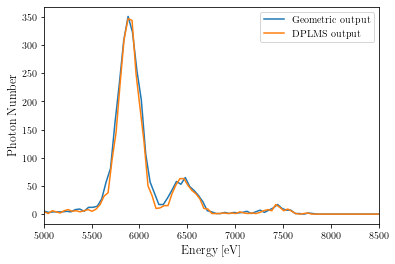

In [53]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
dists = numpy.vstack((eV0, n))
plt.plot(eV0, n, label='Geometric output')
dists_opt = numpy.vstack((eV, n_opt))
plt.plot(eV, n_opt, label='DPLMS output')
plt.legend(loc = 'upper right')
plt.xlim(5000,8500)
plt.ylabel(r'Photon Number ',fontsize=12)
plt.xlabel(r'Energy [eV]',fontsize=12, labelpad=5)
#plt.title(r'Geometrical Shaper versus DPLMS Shaper Output Energy Spectra',fontsize=16)
# normalizar amplitudes 
plt.savefig('plots/geo_dplms.pdf', bbox_inches = 'tight')

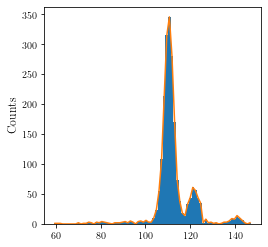

2093


In [54]:
f13 = pandas.read_csv("Figs_data/Fig13-Amplitude, Arrival time, Decay time, Slope, offsets.txt", header=None)
plt.ylabel(r'Counts ',fontsize=12)
n_fit,x_fit,_ = draw_hist(f13[0],1.16)
bin_centers_fit = 0.5*(x_fit[1:] + x_fit[:-1])
plt.plot(bin_centers_fit,n_fit) 
axes=plt.gca()
axes.set_aspect(1.0/axes.get_data_ratio() * 1)
plt.savefig('plots/hist_amp.pdf', bbox_inches = 'tight')
plt.show()
print(len(f13[0]))

-------------------------------
Parameter  	  Value 
g1_amplitude 	  1999.01607
g1_center 	    74.73378
g1_sigma 	     1.20302
g1_fwhm 	   223.26854
g1_height 	   662.91047
g2_amplitude 	   399.00250
g2_center 	    77.11661
g2_sigma 	     1.60718
g2_fwhm 	   298.27751
g2_height 	    99.04242
g3_amplitude 	    99.01000
g3_center 	    91.52173
g3_sigma 	     3.89319
g3_fwhm 	   722.53979
g3_height 	    10.14573


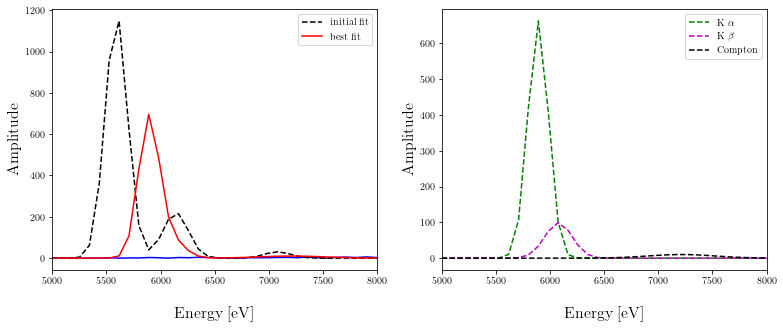

In [55]:
gauss1 = GaussianModel(prefix='g1_')
pars = gauss1.make_params()
pars.update(gauss1.make_params())

pars['g1_center'].set(value=70.95822, min=60, max=75)
pars['g1_sigma'].set(value=1.30438, min=0.3)
pars['g1_amplitude'].set(value=3864.55254, min=1000)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value=77.90659, min=70, max=80)
pars['g2_sigma'].set(value=1.48519, min=0.5)
pars['g2_amplitude'].set(value=821.38221, min=200)

gauss3 = GaussianModel(prefix='g3_')
pars.update(gauss3.make_params())

pars['g3_center'].set(value=89.84883, min=85, max=95)
pars['g3_sigma'].set(value=1.55003, min=1.3)
pars['g3_amplitude'].set(value=118.72250, min=50)

mod = gauss1 + gauss2 + gauss3

init = mod.eval(pars, x=bin_centers_fit)
out_fit = mod.fit(n_fit, pars, x=bin_centers_fit)
comps_fit = out_fit.eval_components(x=bin_centers_fit)

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))

print('-------------------------------')
print('Parameter  \t  Value ')
for name, param in out_fit.params.items():
    if name[0] == 'g':
        if 'fwhm' in name:
            print('{:7s} \t {:11.5f}'.format(name, arb2eV(param.value, out_fit.params['g1_center'], 5890)))
        else:
            print('{:7s} \t {:11.5f}'.format(name, param.value))

eV_fit = arb2eV(bin_centers_fit, out_fit.params['g1_center'], 5890) 
p_fit = 5890 / out_fit.params['g1_center']

axes[0].plot(eV_fit, n_fit, 'b')
axes[0].plot(eV_fit, init, 'k--', label='initial fit')
axes[0].plot(eV_fit, out_fit.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')
axes[0].set_xlim([5000, 8000])

axes[1].plot(eV_fit, comps_fit['g1_'], 'g--', label='K $\\alpha$')
axes[1].plot(eV_fit, comps_fit['g2_'], 'm--', label='K $\\beta$')
axes[1].plot(eV_fit, comps_fit['g3_'], 'k--', label='Compton')
axes[1].legend(loc='best')
axes[1].set_xlim([5000, 8000])

axes[0].set_xlabel(r'Energy [eV]',fontsize=16, labelpad=20)
axes[0].set_ylabel(r'Amplitude ',fontsize=16)
axes[1].set_xlabel(r'Energy [eV]',fontsize=16, labelpad=20)
axes[1].set_ylabel(r'Amplitude ',fontsize=16)
fig0.suptitle(r'Gaussian Fitting of Fitting Shaper Histogram')
plt.show()

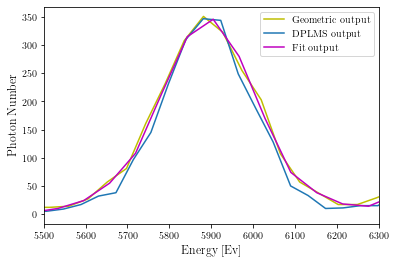

In [69]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
dists = numpy.vstack((eV0, n))
plt.plot(eV0, n, label='Geometric output', color='y')
dists_opt = numpy.vstack((eV, n_opt))
plt.plot(eV, n_opt, label='DPLMS output')
eV_fit = arb2eV(bin_centers_fit, out_fit.params['g1_center']+35.7, 5890) 
dists_fit = numpy.vstack((eV_fit, n_fit))
plt.plot(eV_fit, n_fit, label='Fit output', color='m')
plt.legend(loc = 'upper right')
plt.xlim(5500,6300)
plt.ylabel(r'Photon Number ',fontsize=12)
plt.xlabel(r'Energy [Ev]',fontsize=12, labelpad=5)
#plt.title(r'Geometrical Shaper versus DPLMS Shaper Output Energy Spectra',fontsize=16)
# normalizar amplitudes 
plt.savefig('plots/fit_geo_dplms.pdf', bbox_inches = 'tight')

In [57]:
len(eV), len(n_opt)

(199, 199)

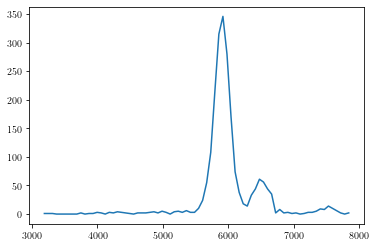

In [58]:
dists_fit = numpy.vstack((eV_fit, n_fit))
plt.plot(eV_fit, n_fit, label='Fit output')

In [59]:
type(eV_fit)

numpy.ndarray

In [60]:
eV_fit[20], n_fit[63]

(4428.057157565638, 0.0)

In [61]:
n_fit.argmax()

44

In [62]:
out_fit.params['g1_center']

<Parameter 'g1_center', value=74.73378495232201, bounds=[60:75]>